In [4]:
##CAPTURING ALL ACTIVITIES IN STRAVA
#THIS UTILIZES STRAVA API
#LAST UPDATED 22-SEPT-2023

import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "109430",
    'client_secret': '9f9bba1f50148b0b7a4996fe4d1e89a300aaeff5',
    'refresh_token': '60918cffb119360a53f6fa56701db6c9581cfd28',
    'grant_type': "refresh_token",
    'f': 'json'
}


##THE REFRESH TOKEN IS FROM THE POST REQUEST## 
##https://www.strava.com/oauth/token?client_id=109430&client_secret=9f9bba1f50148b0b7a4996fe4d1e89a300aaeff5&code=bf81d56e5a81ee7f6f42d8dddbe2fca99c359de3&grant_type=authorization_code


print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)

print(res.text)
print(res.status_code)


access_token = res.json()['access_token']


print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}

# The first loop, request_page_number will be set to one, so it requests the first page. Increment this number after
# each request, so the next time we request the second page, then third, and so on...

request_page_num = 1
all_activities = []
my_dataset = []

while True:
    param = {'per_page': 200, 'page': request_page_num}
    # initial request, where we request the first page of activities
    
    try:
        my_dataset = requests.get(activites_url, headers=header, params=param).json()
        print(my_dataset)
      
    except ValueError:
        print("Error occurred while parsing API response.")
        break

    # check the response to make sure it is not empty. If it is empty, that means there is no more data left. So if you have
    # 1000 activities, on the 6th request, where we request page 6, there would be no more data left, so we will break out of the loop
    
    if len(my_dataset) == 0:
        print("breaking out of while loop because the response is zero, which means there must be no more activities")
        break

    # if the all_activities list is already populated, that means we want to add additional data to it via extend.
    if isinstance(my_dataset, list):
        if all_activities:
            print("all_activities is populated")
            all_activities.extend(my_dataset)
    

        # if the all_activities is empty, this is the first time adding data so we just set it equal to my_dataset
        else:
            print("all_activities is NOT populated")
            all_activities = my_dataset

        request_page_num += 1
    else:
        print("my_dataset is not a list. Skipping this response.")


Requesting Token...

{"token_type":"Bearer","access_token":"ae009f6008af043c19f0170fe6dbe4d43c5d4823","expires_at":1710319184,"expires_in":21557,"refresh_token":"60918cffb119360a53f6fa56701db6c9581cfd28"}
200
Access Token = ae009f6008af043c19f0170fe6dbe4d43c5d4823

[{'resource_state': 2, 'athlete': {'id': 29563579, 'resource_state': 1}, 'name': 'Night Swim', 'distance': 0.0, 'moving_time': 703, 'elapsed_time': 703, 'total_elevation_gain': 0, 'type': 'Swim', 'sport_type': 'Swim', 'id': 10910482389, 'start_date': '2024-03-07T13:14:10Z', 'start_date_local': '2024-03-07T21:14:10Z', 'timezone': '(GMT+08:00) Asia/Singapore', 'utc_offset': 28800.0, 'location_city': None, 'location_state': None, 'location_country': None, 'achievement_count': 0, 'kudos_count': 1, 'comment_count': 0, 'athlete_count': 1, 'photo_count': 0, 'map': {'id': 'a10910482389', 'summary_polyline': '', 'resource_state': 2}, 'trainer': True, 'commute': False, 'manual': False, 'private': False, 'visibility': 'followers_only',

In [13]:
##DATA INVESTIGATION

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(all_activities)


##DATA CLEANSING
#convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

# Filter rows where the year is greater than 2021, type = run, null values
filtered_df = df[df['start_date'].dt.year > 2021]
filtered_df = df[df['type'] == "Run"]

df = filtered_df

features = ["distance", "moving_time", "average_heartrate","elapsed_time",
            "total_elevation_gain","type", "average_cadence" ,"average_speed"]

print(f"SHAPE: {df[features].shape}")
print(f"COLUMNS:{df[features].columns}")
print(f"INFO:{df[features].info()}")

SHAPE: (327, 8)
COLUMNS:Index(['distance', 'moving_time', 'average_heartrate', 'elapsed_time',
       'total_elevation_gain', 'type', 'average_cadence', 'average_speed'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 1 to 671
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              327 non-null    float64
 1   moving_time           327 non-null    int64  
 2   average_heartrate     192 non-null    float64
 3   elapsed_time          327 non-null    int64  
 4   total_elevation_gain  327 non-null    float64
 5   type                  327 non-null    object 
 6   average_cadence       317 non-null    float64
 7   average_speed         327 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 23.0+ KB
INFO:None


Correlation Matrix:
                      distance  moving_time  average_heartrate  elapsed_time  \
distance              1.000000     0.979052          -0.065496      0.964767   
moving_time           0.979052     1.000000          -0.100520      0.985001   
average_heartrate    -0.065496    -0.100520           1.000000     -0.105288   
elapsed_time          0.964767     0.985001          -0.105288      1.000000   
total_elevation_gain  0.517280     0.514369          -0.084940      0.497483   
average_cadence      -0.249228    -0.369824           0.489768     -0.373965   
average_speed        -0.215677    -0.309617           0.552694     -0.299647   

                      total_elevation_gain  average_cadence  average_speed  
distance                          0.517280        -0.249228      -0.215677  
moving_time                       0.514369        -0.369824      -0.309617  
average_heartrate                -0.084940         0.489768       0.552694  
elapsed_time                   

NameError: name 'sns' is not defined

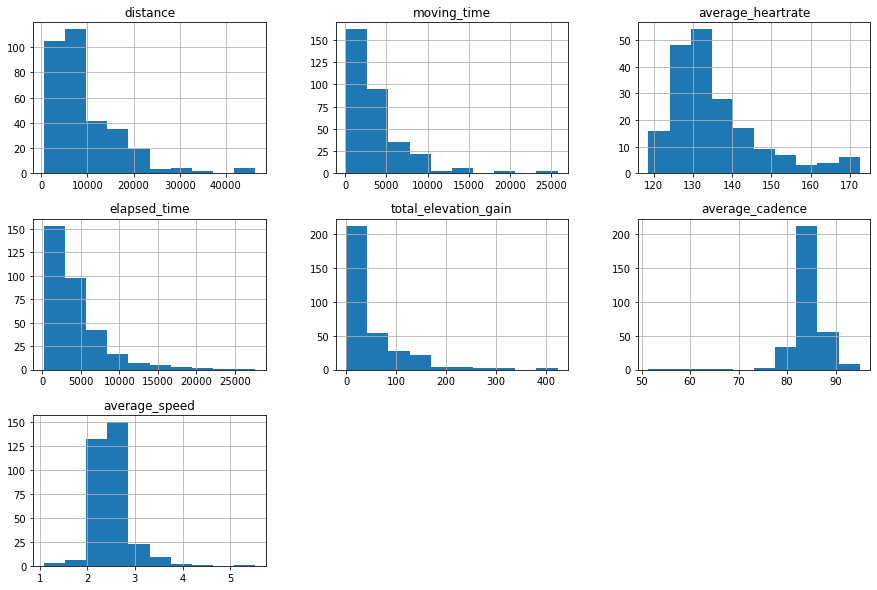

<Figure size 576x432 with 0 Axes>

In [15]:
##CORRELATION PLOT

from scipy.stats import pearsonr

##DATA CLEANSING
#convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

# Filter rows where the year is greater than 2021, type = run, drop null
filtered_df = df[df['start_date'].dt.year > 2021]
filtered_df = df[df['type'] == "Run"]


##FEATURE SELECTION
features = ["distance", "moving_time", "average_heartrate","elapsed_time",
            "total_elevation_gain","type", "average_cadence" ,"average_speed"]


df[features].hist(figsize=(15, 10));

data = df[features]


correlation_matrix = data.corr()

print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [ ]:
##LINEAR REGRESSION

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Select features
features = ["distance", "moving_time", "average_heartrate", "elapsed_time",
            "total_elevation_gain", "average_cadence", "average_speed"]

# data = filtered_df[features]

X = filtered_df[features]
y = filtered_df["moving_time"]

# Step 2: Check index alignment
assert (X.index == y.index).all()

# Handle missing and infinite values
X.dropna(inplace=True)
y.dropna(inplace=True)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Checking data dimension
print(X_train.shape)
print(y_train.shape)


##Checking data types
print(X_train.info())
print(y_train.info())

##Checking data dimension

print(X_train.shape)
print(y_train.shape)


# # # Create and train the Linear Regression model
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# # Make predictions
# y_pred = regressor.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R-squared: {r2}")


C:\Users\king.m\AppData\Local\Temp\ipykernel_7580\2492673391.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)
C:\Users\king.m\AppData\Local\Temp\ipykernel_7580\2492673391.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\king.m\AppData\Local\Temp\ipykernel_7580\2492673391.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


ValueError: Found input variables with inconsistent numbers of samples: [162, 297]